### Libraries

In [1]:
import os
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn
from joblib import dump

List of scopes according to the type of access: https://developers.google.com/drive/api/v3/about-auth

### Credentials to access Google Drive

In [2]:
scopes = ["https://www.googleapis.com/auth/drive"]



In [3]:
creds = None

if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json',scopes)
    
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
        
    else:
        flow = InstalledAppFlow.from_client_secrets_file('client_secret.json', scopes)
        creds = flow.run_local_server(port=0)
        
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

### Get file IDs

In [4]:
try:
    service =  build('drive', 'v3' , credentials = creds)
    ##### OPERACION DE LISTADO DE ARCHIVOS #############
    results =  service.files().list(
        pageSize = 5,
        q= "name contains 'wine'",
        spaces= 'drive',
        fields= "nextPageToken, files(id,name)").execute()
    items = results.get('files',[])
    if not items:
        print("No hay items")
    for item in items:
        print(f"name {item['name']} , id {item['id']}")
except HttpError as error:
    print(f'Ocurrió un error {error}')

name winequality-red.csv , id 1uR5RpBfR7CHlM8WdDjbuV-PSC6eu2ZwU
name winequality.zip , id 16QXPDPk0gQqUCN4kJzYD1Ntct4XPMvwF
name winequality-white.csv , id 1jf4TZfxmPFxARCctaRF_F9sEst8mk2Hm


### Files are downloaded

In [5]:
def download_file(real_file_id, name_file, ext_file):
    try:
        # create drive api client
        service = build('drive', 'v3', credentials=creds)
        file_id = real_file_id
        # pylint: disable=maybe-no-member
        request = service.files().get_media(fileId=file_id)
        file = io.FileIO("{}.{}".format(name_file, ext_file), mode='w')
        downloader = MediaIoBaseDownload(file, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(F'Download {int(status.progress() * 100)}.')

    except HttpError as error:
        print(F'An error occurred: {error}')
        file = None
    return '{}.{}'.format(name_file, ext_file)


In [6]:
wine_white = download_file("1jf4TZfxmPFxARCctaRF_F9sEst8mk2Hm", "wine_white", "csv")
wine_red = download_file("1uR5RpBfR7CHlM8WdDjbuV-PSC6eu2ZwU", "wine_red", "csv")

Download 100.
Download 100.


### Dataframes from downloaded files

In [7]:
df_wine_white = pd.read_csv(wine_white, sep=';')
df_wine_red = pd.read_csv(wine_red, sep=';')

In [8]:
df_wine_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [9]:
df_wine_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Data processing

Creating the target variable for each dataframe

In [10]:
df_wine_red['target'] = 'R'
df_wine_white['target'] = 'W'

Cutting the Wine White dataframe so that it has the same number of records as the Wine Red

In [11]:
df_wine_white = sklearn.utils.shuffle(df_wine_white)[:1599].reset_index(drop=True)

In [12]:
# comprobando que tengan el mismo número de registros y columnas 
print(df_wine_white.shape)
print(df_wine_red.shape)

(1599, 13)
(1599, 13)


Joining the two dataframes into a single dataframe

In [13]:
wines = pd.concat([df_wine_red, df_wine_white])
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,R
1,7.8,0.88,0.00,2.60,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,R
2,7.8,0.76,0.04,2.30,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,R
3,11.2,0.28,0.56,1.90,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,R
4,7.4,0.70,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.6,0.33,0.41,2.00,0.027,14.0,79.0,0.99063,3.27,0.63,12.4,6,W
1595,8.4,0.31,0.31,0.95,0.021,52.0,148.0,0.99038,2.93,0.32,11.5,5,W
1596,7.4,0.30,0.49,8.20,0.055,49.0,188.0,0.99740,3.52,0.58,9.7,6,W
1597,6.4,0.33,0.28,1.10,0.038,30.0,110.0,0.99170,3.12,0.42,10.5,6,W


Mixing the dataframe to prevent the model from learning incorrectly

In [14]:
wines_shuffled = sklearn.utils.shuffle(wines).reset_index(drop=True)
wines_shuffled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,8.2,0.400,0.31,1.90,0.082,8.0,24.0,0.99600,3.24,0.69,10.6,6,R
1,7.0,0.620,0.08,1.80,0.076,8.0,24.0,0.99780,3.48,0.53,9.0,5,R
2,7.4,0.965,0.00,2.20,0.088,16.0,32.0,0.99756,3.58,0.67,10.2,5,R
3,5.7,0.220,0.22,16.65,0.044,39.0,110.0,0.99855,3.24,0.48,9.0,6,W
4,10.2,0.540,0.37,15.40,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6,R


In [15]:
# obteniendo la forma de nuestros datos
wines_shuffled.shape

(3198, 13)

In [16]:
# obteniendo el nombre de las columnas
wines_shuffled.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'target'],
      dtype='object')

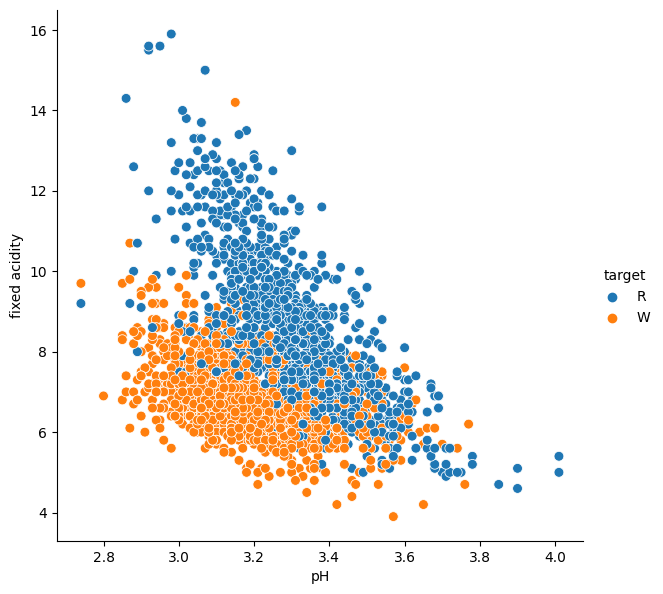

In [17]:
# observamos una pequeña visualización de dos variables ph y fixed acidity
sns.pairplot(
    x_vars='pH', y_vars='fixed acidity', 
    hue='target', data=wines_shuffled, height = 6, plot_kws={"s": 50})

### Data separation for training and testing

In [18]:
x_wines = wines_shuffled.drop(columns='target').values

In [19]:
y_wines = wines_shuffled['target'].values

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x_wines, y_wines, shuffle=True,test_size = 0.40)

### Rescaling data

In [21]:
# estandarizar los valores que se utilizaran en el entrenamiento
scaler = MinMaxScaler()
scaler.fit(x_train)

MinMaxScaler()

In [22]:
# re-escalo de las variables
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
# vemos el minimo y maximo de los valores de entrenamiento
x_train.min(), x_train.max()

(0.0, 1.0000000000000002)

### Model

In [24]:
# utilizmos el módelo Kneighbors con nuestra k tentativa de 3
classifier = KNeighborsClassifier(n_neighbors = 3)


### Model Training

In [26]:
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Testing the model with predictions

In [27]:
# predictions
y_pred = classifier.predict(x_test)

### Model metrics

In [28]:
# function for confusion matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

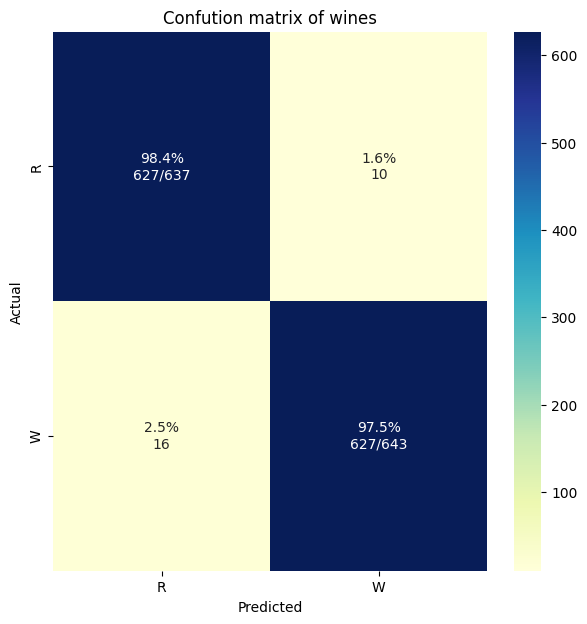

In [29]:
# Showing Confusion Matrix
plot_cm(y_test, y_pred, 'Confution matrix of wines', figsize=(7,7))

In [30]:
# We get the metrics of the model, to know how reliable it is
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           R       0.98      0.98      0.98       637
           W       0.98      0.98      0.98       643

    accuracy                           0.98      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280



### Saving the model

In [31]:
dump(classifier, 'models/classifier_wines.joblib')

['models/classifier_wines.joblib']